In [176]:
from matplotlib import pyplot as plt
%matplotlib notebook
import glob
import os
import cv2
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import os
from IPython.display import Image
import json
import tqdm
import xml.etree.ElementTree as ET

In [25]:
DATASTE_FOLDER="/Users/user421/datasets/ICDAR2019_cTDaR/training/"

track_a_train = os.path.join(DATASTE_FOLDER, "TRACKA", "ground_truth")
track_b1_train = os.path.join(DATASTE_FOLDER, "TRACKB1", "ground_truth")
track_b2_train = os.path.join(DATASTE_FOLDER, "TRACKB2", "ground_truth")


track_a_train_images = sorted(glob.glob("{}/*jpg".format(track_a_train)))
track_b1_train_images = sorted(glob.glob("{}/*jpg".format(track_b1_train)))
track_b2_train_images = sorted(glob.glob("{}/*jpg".format(track_b2_train)))


track_a_train_annotations = sorted(glob.glob("{}/*xml".format(track_a_train)))
track_b1_train_annotations = sorted(glob.glob("{}/*xml".format(track_b1_train)))
track_b2_train_annotations = sorted(glob.glob("{}/*xml".format(track_b2_train)))


print("Total track_a_train_images images={}. Total track_a_train_annotations annotations={}."
      .format(len(track_a_train_images), len(track_a_train_annotations)))

print("Total track_b1_train_images images={}. Total track_b1_train_annotations annotations={}."
      .format(len(track_b1_train_images), len(track_b1_train_annotations)))

print("Total track_b2_train_images images={}. Total track_b2_train_annotations annotations={}."
      .format(len(track_b2_train_images), len(track_b2_train_annotations)))


Total track_a_train_images images=1123. Total track_a_train_annotations annotations=1200.
Total track_b1_train_images images=523. Total track_b1_train_annotations annotations=600.
Total track_b2_train_images images=0. Total track_b2_train_annotations annotations=0.


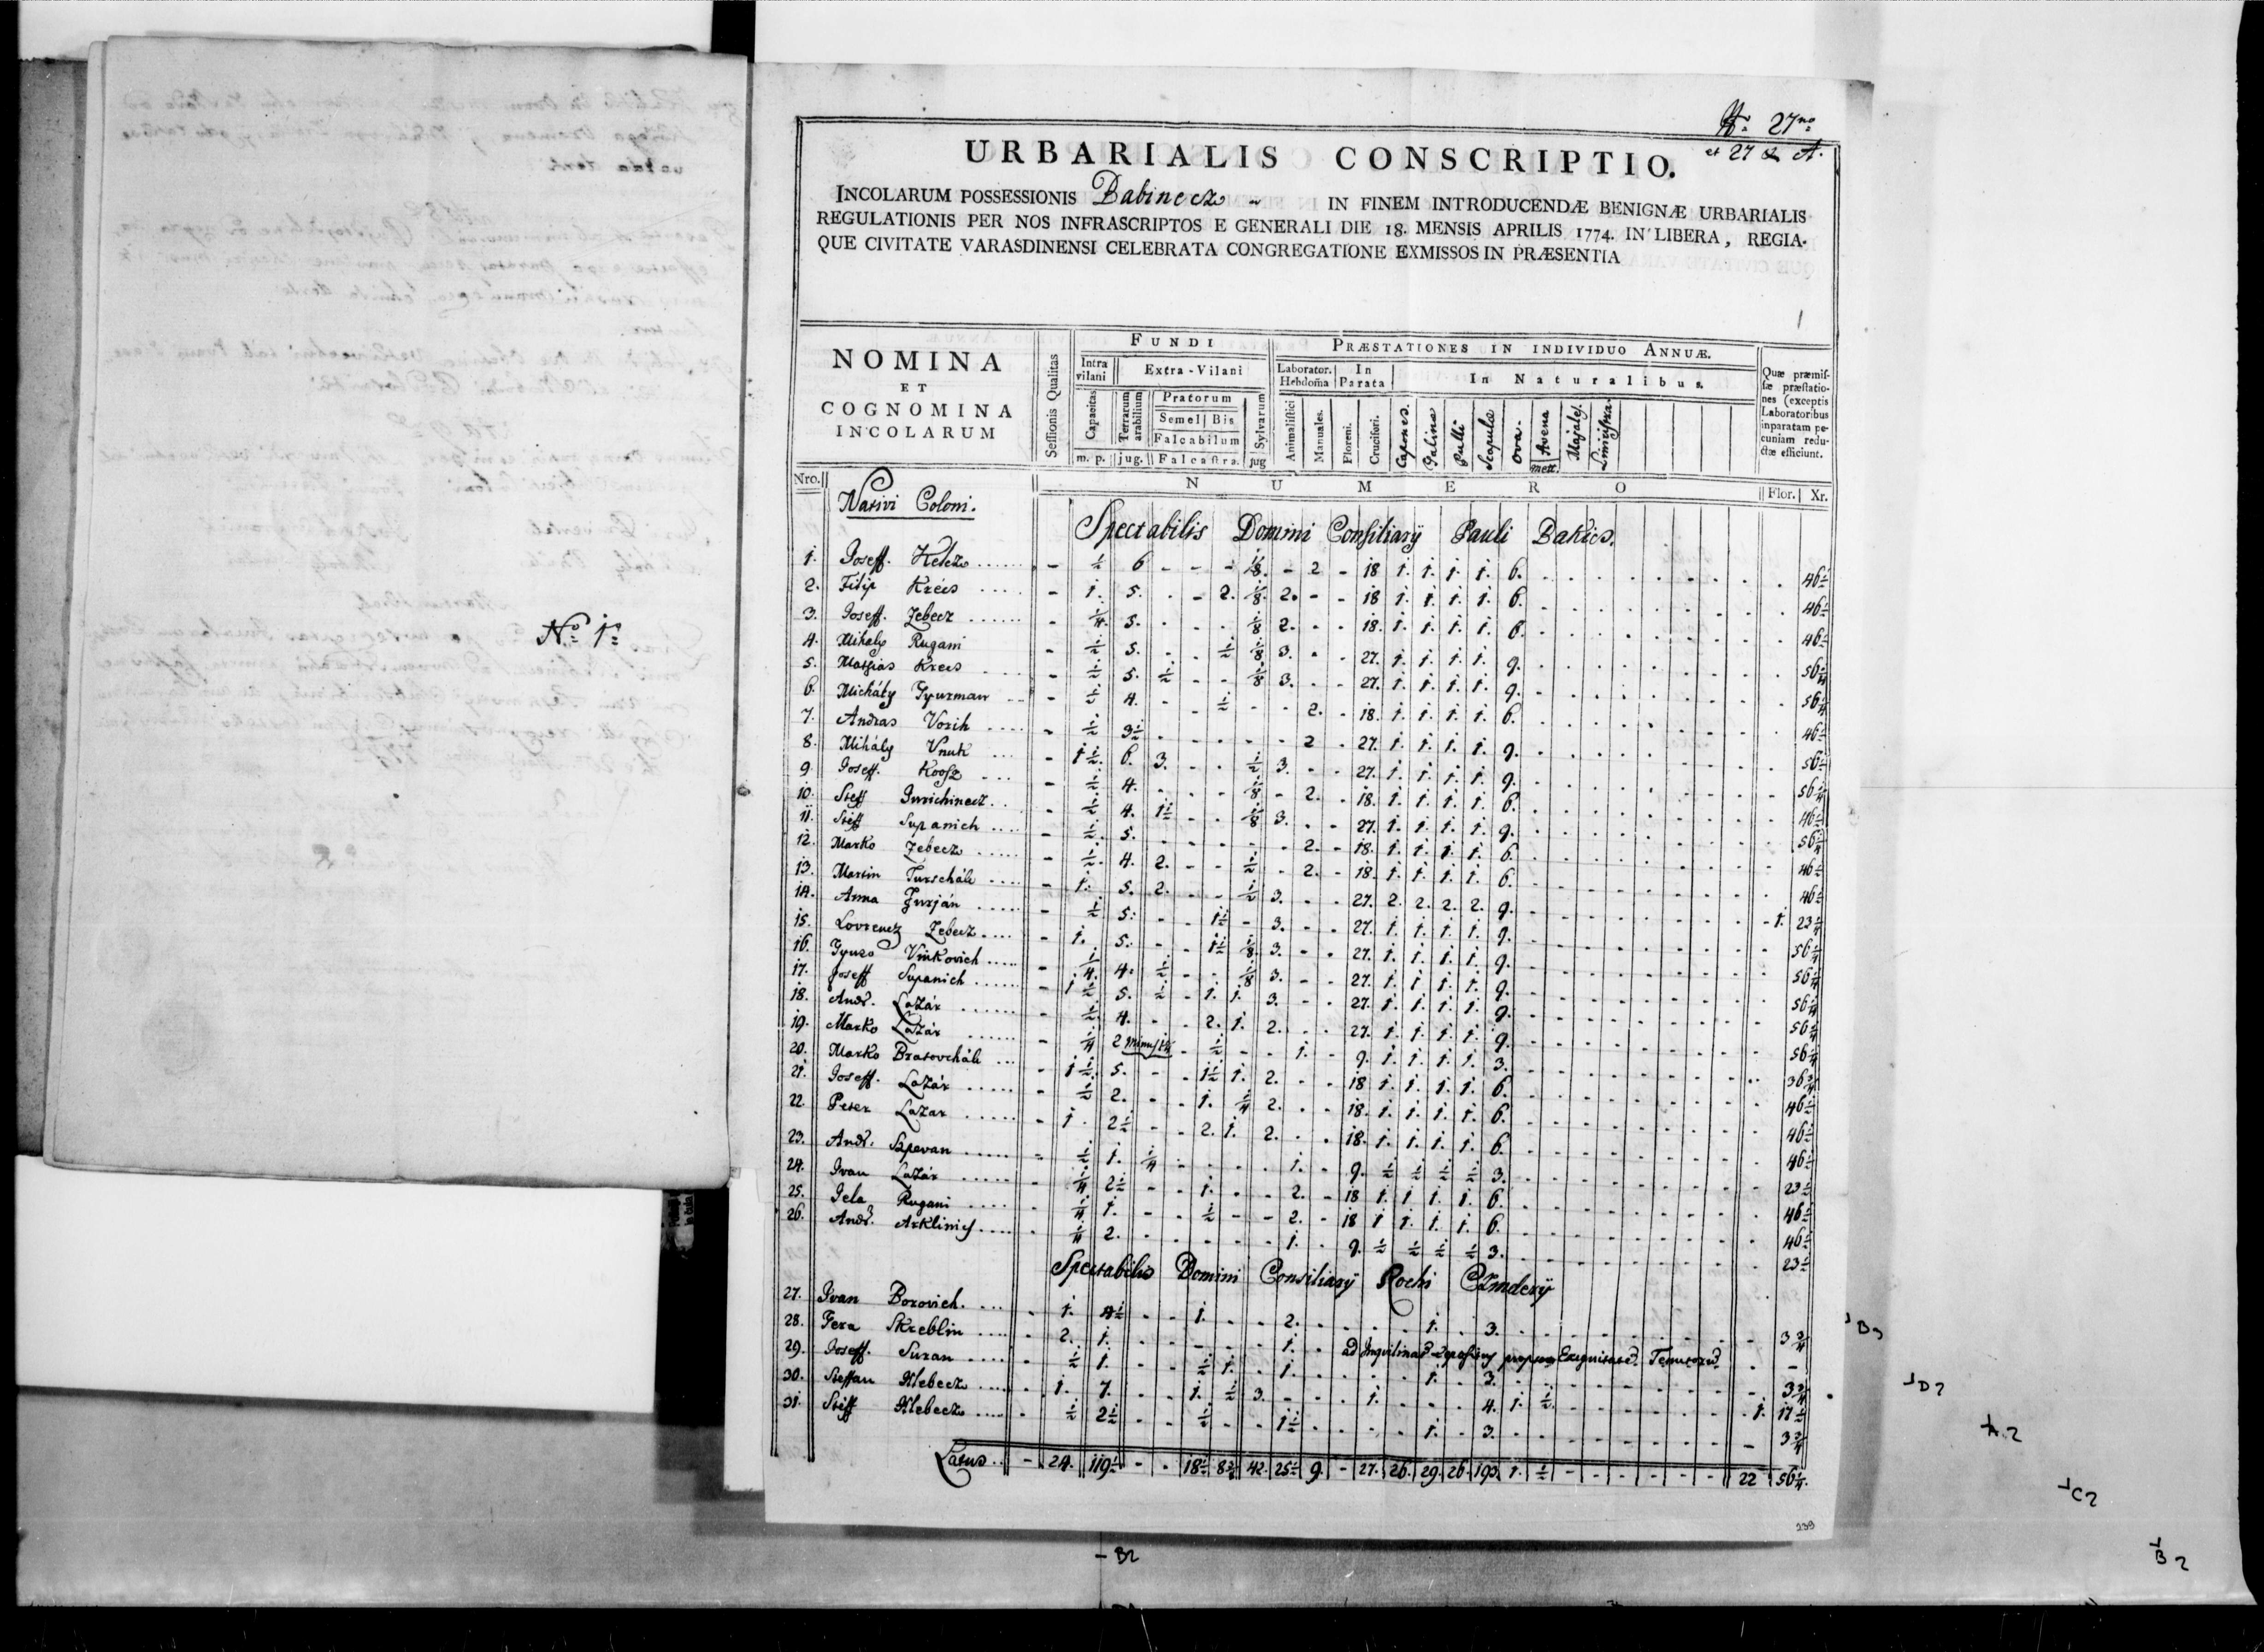

In [27]:
display(Image(data=track_a_train_images[0]))

In [28]:
print ("Train A Ann:")
!cat {track_a_train_annotations[-1]}
print("++++++++++++++++++++++++++++")
print ("Train B1 Ann:")
!cat {track_b1_train_annotations[-1]}
print("++++++++++++++++++++++++++++")
print ("Train B2 Ann:")
!cat {track_b2_train_annotations[-1]}
print("++++++++++++++++++++++++++++")

Train A Ann:
﻿<?xml version="1.0" encoding="UTF-8"?>
<document filename="cTDaR_t10599.jpg">
  <table>
    <Coords points="60,113 60,554 743,554 743,113" />
  </table>
</document>++++++++++++++++++++++++++++
Train B1 Ann:
<?xml version='1.0' encoding='UTF-8'?>
<document filename="cTDaR_t00930.jpg">
  <table>
    <Coords points="161,585 2458,585 2458,3416 161,3416"/>
    <cell start-row="0" end-row="0" start-col="0" end-col="0">
      <Coords points="165,590 163,748 413,748 413,591"/>
    </cell>
    <cell start-row="1" end-row="1" start-col="0" end-col="0">
      <Coords points="163,748 162,844 413,844 413,748"/>
    </cell>
    <cell start-row="0" end-row="0" start-col="1" end-col="1">
      <Coords points="413,591 413,748 525,748 524,589"/>
    </cell>
    <cell start-row="1" end-row="1" start-col="1" end-col="1">
      <Coords points="413,748 413,844 525,844 525,748"/>
    </cell>
    <cell start-row="0" end-row="0" start-col="2" end-col="2">
      <Coords points="524,589 525,748 191

++++++++++++++++++++++++++++
Train B2 Ann:
cat: {track_b2_train_annotations[-1]}: No such file or directory
++++++++++++++++++++++++++++


In [184]:
class Constants:
    RED = [0, 0, 255]
    GREEN = [0, 0, 255]
    BLUE = [255,0, 0]
    CYAN = [255, 255, 0]
    
    
class Coords():
    def __init__(self, points):
        self.points = points
    
        self._points_array=np.array(list(map(lambda point: list(map(int, point.split(","))), points.split(" "))))
        self.xmin, self.ymin, self.xmax, self.ymax = min(self._points_array[:,0]), \
                                                    min(self._points_array[:,1]), \
                                                    max(self._points_array[:,0]), \
                                                    max(self._points_array[:,1]) \
     
    def __repr__(self):
        return f"Coords(points={self.points})"

class Cell:
    def __init__(self, coords, start_row, end_row, start_col, end_col):
        self.coords = Coords(*coords) if not isinstance(coords, Coords) else coords
        self.start_row = start_row
        self.end_row = end_row
        self.start_col = start_col
        self.end_col = end_col
        
    def __getitem__(self, item):
        if not hasattr(self, item):
            raise KeyError(f"{item} is not present in {self.__class__}")
        return getattr(self, item)
    
    def __repr__(self):
        return f"Cell(coords={self.coords}, start_row={self.start_row}, end_row={self.end_row}), start_col={self.start_col}, end_col={self.end_col})"
        
    
class Table:
    def __init__(self, coords, cells):
        
        self.coords = Coords(*coords) if not isinstance(coords, Coords) else coords
        self.cells = [ Cell(**cell) if not isinstance(cell, Cell) else cell for cell in cells ] 
    
    def __getitem__(self, item):
        if not hasattr(self, item):
            raise KeyError(f"{item} is not present in {self.__class__}")
        return getattr(self, item)
    
    def __repr__(self):
        return f"Table(coords={self.coords}, cells={self.cells})"
    
class Document():
    def __init__(self, tables):
        self.tables = [Table(**table)  if not isinstance(table, Table) else table  for table in tables]
        
    def __repr__(self):
        return f"Document(tables={self.tables})"

In [185]:

def parse_xml_annotation(tree):
    if tree.tag == "document":
        tables = [ parse_xml_annotation(table) for table in tree.getchildren()]
        return Document(tables)
    elif tree.tag == "table":
        coords = Coords(**tree.find("Coords").attrib)
        cells = [ parse_xml_annotation(cell) for cell in tree.getchildren() if cell.tag == "cell"]
        return Table(coords=coords, cells=cells)
    elif tree.tag == "cell":
        cell = tree
        coords = Coords(**tree.find("Coords").attrib)
        return Cell(coords=coords, **{cell_attrib.replace("-","_"): cell_attrib_val 
                       for cell_attrib, cell_attrib_val in cell.attrib.items()}) 


In [186]:
def color_image(image, annotation):

    for table in annotation.tables:
        cv2.rectangle(image, (table.coords.xmin, table.coords.ymin), (table.coords.xmax, table.coords.ymax), Constants.RED, 10)

        for cell in table.cells:
            cv2.rectangle(image, (cell.coords.xmin, cell.coords.ymin), (cell.coords.xmax, cell.coords.ymax), Constants.CYAN, 4)
        
    return image


In [189]:

annotations= []
colored_images = {}
train_images_dir = track_b1_train_images[0].rsplit("/",1)[0]


for train_annotation in tqdm.tqdm_notebook(track_b1_train_annotations, total=len(track_b1_train_annotations)):
    with open(train_annotation) as fp:
        tree = ET.parse(train_annotation)
        annotation = parse_xml_annotation(tree.getroot())
        xml_name = os.path.relpath( train_annotation, train_annotation.rsplit("/",1)[0])
        file_name = xml_name.replace(".xml", ".jpg")
        if os.path.exists(os.path.join(train_images_dir, file_name)):
            colored_images[file_name] = color_image(cv2.imread(os.path.join(train_images_dir, file_name)), annotation)
        annotations.append(annotation)



In [180]:

@interact
def show_images(image_file=list(colored_images.keys())):
    
    image = colored_images[image_file]
    cv2.imwrite("temp.jpg", image)
    
    display(Image(data="temp.jpg"))
    
    

interactive(children=(Dropdown(description='image_file', options=('cTDaR_t00000.jpg', 'cTDaR_t00001.jpg', 'cTD…

<IPython.core.display.Javascript object>


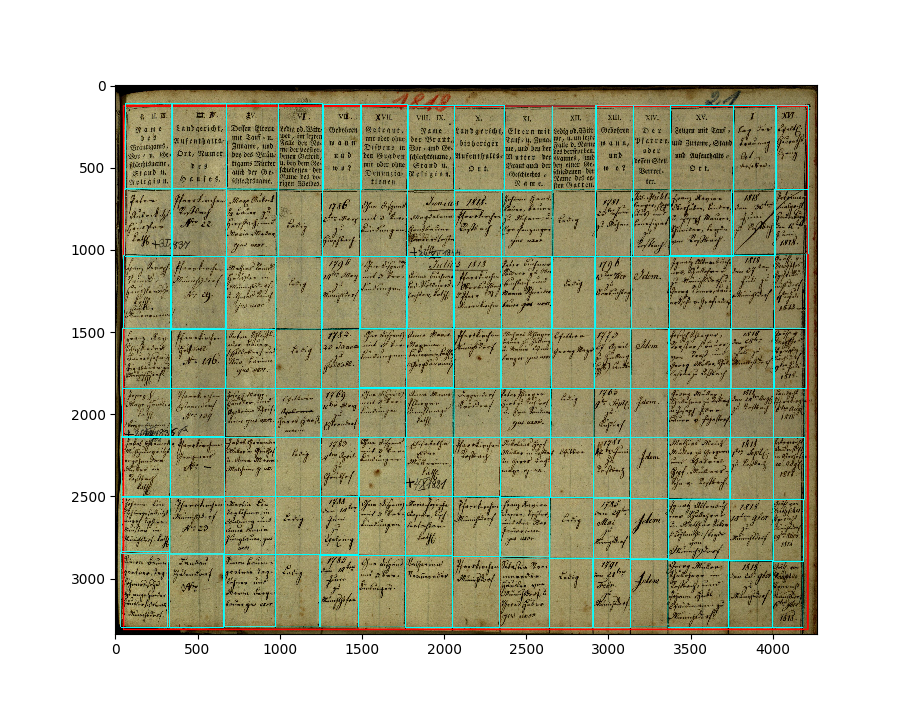

In [190]:
plt.imshow(plt.imread("temp.jpg"))